In [1]:
#装载谷歌云盘
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd  /content/drive/MyDrive/Dissertation Final（MLP+PSO+SOLVE）
!pip install torch==1.12.1

/content/drive/MyDrive/Dissertation Final（MLP+PSO+SOLVE）
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 3.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0+cu121
    Uninstalling torch-2.4.0+cu121:
      Successfully uninstalled torch-2.4.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.0+cu121 requires torch==2.4.0, but you have torch 1.12.1 which is incompatible.
torchvision 0.19.0+cu121 requires torch==2.4.0, but you have torch 1.12.1 which is incompatible.


cuda
Epoch [100/5000], Loss: -1.335903
Epoch [200/5000], Loss: -1.338186
Epoch [300/5000], Loss: -1.338760
Epoch [400/5000], Loss: -1.338990
Epoch [500/5000], Loss: -1.339104
Epoch [600/5000], Loss: -1.339170
Epoch [700/5000], Loss: -1.339211
Epoch [800/5000], Loss: -1.339239
Epoch [900/5000], Loss: -1.339258
Epoch [1000/5000], Loss: -1.339272
Epoch [1100/5000], Loss: -1.339283
Epoch [1200/5000], Loss: -1.339290
Epoch [1300/5000], Loss: -1.339297
Epoch [1400/5000], Loss: -1.339302
Epoch [1500/5000], Loss: -1.339307
Epoch [1600/5000], Loss: -1.339310
Epoch [1700/5000], Loss: -1.339313
Epoch [1800/5000], Loss: -1.339315
Epoch [1900/5000], Loss: -1.339317
Epoch [2000/5000], Loss: -1.339319
Epoch [2100/5000], Loss: -1.339320
Epoch [2200/5000], Loss: -1.339322
Epoch [2300/5000], Loss: -1.339323
Epoch [2400/5000], Loss: -1.339324
Epoch [2500/5000], Loss: -1.339325
Epoch [2600/5000], Loss: -1.339325
Epoch [2700/5000], Loss: -1.339326
Epoch [2800/5000], Loss: -1.339327
Epoch [2900/5000], Loss:

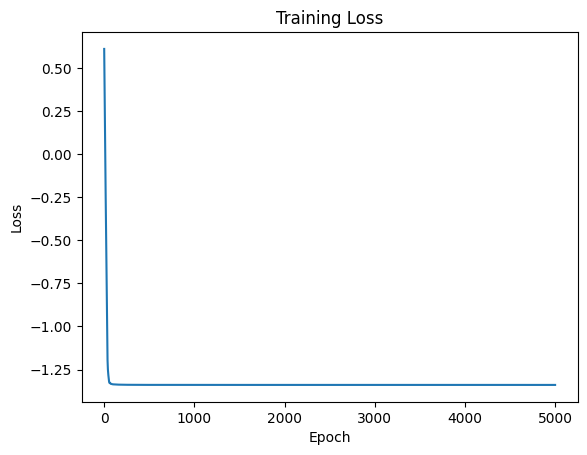

Time taken: 6.991083383560181 seconds


In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # 导入pandas来读取Excel文件
import warnings
import time
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

start_time = time.time()
returns=pd.read_excel('8stocks.xlsx').values
returns_tensor=torch.tensor(returns, dtype=torch.float32)
rfr=0.03

def portfolio_fitness(weights,returns_tensor,rfr):
  portfolio_returns=torch.sum(returns_tensor.mean(0)*weights)*252
  covariance_matrix=torch.cov(returns_tensor.T)
  portfolio_volatility=torch.sqrt(torch.matmul(weights.T,torch.matmul(covariance_matrix*252,weights)))
  portfolio_sharpe_ratio=(portfolio_returns-rfr)/portfolio_volatility
  return portfolio_returns,portfolio_volatility,portfolio_sharpe_ratio

class PortfolioOptimizationNN(nn.Module):
  def __init__(self,input_size):
    super(PortfolioOptimizationNN,self).__init__()
    self.fc1=nn.Linear(input_size,128)
    self.fc2=nn.Linear(128,64)
    self.fc3=nn.Linear(64,input_size)
    self.softmax=nn.Softmax(dim=1)

  def forward(self,x):
    x=torch.relu(self.fc1(x))
    x=torch.relu(self.fc2(x))
    x=self.fc3(x)
    x=self.softmax(x)
    return x

num_epochs=5000
learning_rate=0.001

input_size=returns_tensor.shape[1] #shape[0]代表有几行，1是代表有几列。
model=PortfolioOptimizationNN(input_size)
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
#optimizer=optim.SGD(model.parameters(),lr=learning_rate)

losses=[]
for epoch in range(num_epochs):
  model.train()
  optimizer.zero_grad() #历史梯度清零

  weights=model(torch.ones(1,input_size))
  weights=weights.requires_grad_(True)
  portfolio_returns,portfolio_volatility,portfolio_sharpe_ratio=portfolio_fitness(weights[0],returns_tensor,rfr)
  loss=-portfolio_sharpe_ratio
  loss.backward()#误差反向传播
  optimizer.step()#优化器去进行下一步

  losses.append(loss.item())
  if (epoch+1)%100==0:
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}") #6f几位小数
#训练1000轮模型完已经更新好w和b，传入全1的向量，去计算权重。

optimal_weights=model(torch.ones(1,input_size)).detach().numpy()

portfolio_returns, portfolio_volatility, _ = portfolio_fitness(torch.tensor(optimal_weights[0]), returns_tensor, rfr)

print("Optimal Weights:",optimal_weights)

print(f"Final Portfolio Returns: {portfolio_returns:.6f}")
print(f"Final Portfolio Volatility: {portfolio_volatility:.6f}")

plt.plot(range(num_epochs),losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

end_time = time.time()
print(f'Time taken: {end_time - start_time} seconds')